This notebook follows from rotate_no_resize_inference and running the nn-Unet model. It is used to find the Dice and sDice metric results. This script is to calculate the DICE, sDICE, and the Hausdorff distance of two sets of labels. The sets of labels are called (a) original for the manual labels and (b) predicted for the predicted labels
Documentation of metrics can be found here: https://github.com/deepmind/surface-distance


In [1]:
#Necessary imports
import os
import shutil

from ast import Break
import os
import SimpleITK as sitk
import numpy as np

import re

from absl.testing import absltest
from absl.testing import parameterized
import surface_distance
from surface_distance import metrics

import pandas as pd



In [2]:
#Set all paths

nnUnet_res= '/home/chloe/nnUNet_Results/Task603_SettingUp_Res' #Change this to where you store nnUnet results
predicted_labels = 'results/control_results/control_predictions'
rot_dir = 'results/control_results/control_images'

original_label_dir = 'data/labelsTs'
transformed_labels = 'results/control_results/control_labels'
stored_control_labels = 'results/control_results/stored_control_labels'

Only run two below if needed

Copy the results to the current working directory

In [3]:
#Maybe add to only move image outputs
file_names = os.listdir(nnUnet_res)

#Make list of strings to create directory: original, control_image, load_save
control_names = ['original', 'control', 'load_save']

for file_name in file_names:
    for name in control_names:
        stored_rot_path = os.path.join(predicted_labels,name)
        if not os.path.exists(stored_rot_path):
            os.makedirs(stored_rot_path)
        if name == 'original':
            if file_name.endswith("pre.nii.gz"):
                shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)
        if file_name.endswith(name+"_image_0.0_0.0_0.0.nii.gz"):
            shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)
        


Move transformed manual labels into folder for computing Dice and sDice metrics

In [9]:
#Store original, untransformed labels
original_labels = os.listdir(original_label_dir)
stored_orig_path = os.path.join(stored_control_labels,'original')
if not os.path.exists(stored_orig_path):
            os.makedirs(stored_orig_path)

for label in original_labels:
    shutil.copy(os.path.join(original_label_dir, label), stored_orig_path)

patient_names = os.listdir(transformed_labels)

#Store transformed control labels
for patient in patient_names:
    patient_path = os.path.join(transformed_labels, patient)
    files = os.listdir(patient_path)
    for file_name in files:
        if file_name.endswith("control_label_0.0_0.0_0.0.nii.gz"):
            stored_rot_path = os.path.join(stored_control_labels,'control')
            if not os.path.exists(stored_rot_path):
                os.makedirs(stored_rot_path)
            shutil.copy(os.path.join(patient_path, file_name), stored_rot_path)
        if file_name.endswith("load_save_label_0.0_0.0_0.0.nii.gz"):
            stored_rot_path = os.path.join(stored_control_labels,'load_save')
            if not os.path.exists(stored_rot_path):
                os.makedirs(stored_rot_path)
            shutil.copy(os.path.join(patient_path, file_name), stored_rot_path)

print("Files copied")

Files copied


Give names for predicted labels and rotated manual labels

In [6]:
#Loop over all the rotations

transform_label_dir = transformed_labels
stored_label_folder = stored_control_labels

original_label_path = stored_label_folder 
predicted_label_path = predicted_labels

Set initial values and functions

In [7]:
def generate_np_array_of_single_structure(np_matrix, number):
    single_struct_array = np.where(np_matrix != number, 0, np_matrix)
    return single_struct_array.astype('bool')    # sets all 0-entries to False, and all others to True

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

num_structures = 1 + 1
s_dice_tolerance = 2 #mm

Iterate over file paths to obtain the metric

In [10]:
dice_matrix = np.zeros(num_structures)
hd_matrix = np.zeros(num_structures)
avg_surface_d_matrix = np.zeros(num_structures)
surf_dice_matrix = np.zeros(num_structures)

num_patients = 0
all_numbers = []
for i in range(num_structures):
    all_numbers.append(i)
print("all_numbers: ", all_numbers)

rot_list =  sorted_alphanumeric(os.listdir(predicted_label_path))
first_file_list = sorted_alphanumeric(os.listdir(os.path.join(original_label_path, rot_list[0])))

dice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)
sdice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)

rot_count = -1
for rot in rot_list:
    rot_count = rot_count + 1
    rot_pred_path = os.path.join(predicted_label_path, rot)
    rot_orig_path = os.path.join(original_label_path, rot)
    file_count = -1
    for filename in sorted_alphanumeric(os.listdir(rot_pred_path)):
        print("Predicting", filename)
        file_count = file_count + 1
        num_patients += 1
        dice_arr = np.zeros(num_structures)
        hd_arr = np.zeros(num_structures)
        avg_surface_d_arr = np.zeros(num_structures)
        surf_dice_arr = np.zeros(num_structures)

        # extract the example name
        # first split the path by '/' and take the last result to get the file name
        # then exclude the last 7 characters to exclude the '.nii.gz'
        name = filename.split('/')[-1][:-7]


        ############ ORIGINAL ############

        # read the label file and save it as nifti with correct naming
        orig_name = name.replace("0000_","")
        orig_name = orig_name.replace("image","label")
        original_data_path = rot_orig_path + "/" +  orig_name + ".nii.gz"
        original_img = sitk.ReadImage(original_data_path)  # read the file (file is the path to the label file)
        original_arr = sitk.GetArrayFromImage(original_img)

        # count amount of pixels with different labels
        unique, counts = np.unique(original_arr, return_counts=True)

        ############ PREDICTIONS ############

        # do the same for the corresponding image file
        pred_data_path = rot_pred_path + "/" +  name + ".nii.gz"
        pred_img = sitk.ReadImage(pred_data_path)  # exchange the _labels with _predictions in the file name to get the path to the predictions and reads the predictions
        pred_arr = sitk.GetArrayFromImage(pred_img)                 

        # count amount of pixels with different labels
        unique2, counts2 = np.unique(pred_arr, return_counts=True)

    #for each structure
        for number in range(num_structures):

            # no evalutation for background
            if(number == 0): continue

            if(number in unique2):
                #print("Analyzing structure: ", number)
                original_structure = generate_np_array_of_single_structure(original_arr, number)
                predicted_structure = generate_np_array_of_single_structure(pred_arr, number)

                # 3rd agument spacing_mm: resp. 3-element list-like structure. Voxel spacing in x0, x1 and x2 directions.
                surf_dist = metrics.compute_surface_distances(original_structure, predicted_structure, [3, 1, 1])
                dice = metrics.compute_dice_coefficient(original_structure, predicted_structure)

                # 2nd argument: percent: a float value between 0 and 100
                hd = metrics.compute_robust_hausdorff(surf_dist, 99)
                avg_sd = metrics.compute_average_surface_distance(surf_dist)
                s_dice = metrics.compute_surface_dice_at_tolerance(surf_dist, s_dice_tolerance)

                dice_arr[number] = dice
                hd_arr[number] = hd
                surf_dice_arr[number] = s_dice

            else: 
                # check if a predicted structure is missing
                print("missing structure in prediction: ", number)


            #Fill in array for each file (each row = rotation, each column = patient )
            dice_array[rot_count,file_count] = dice_arr[1]
            sdice_array[rot_count,file_count] = surf_dice_arr[1]

            dice_matrix = np.vstack((dice_matrix, dice_arr))
            hd_matrix = np.vstack((hd_matrix, hd_arr))
            #avg_surface_d_matrix = np.vstack(avg_surface_d_matrix, avg_surface_d_arr)
            surf_dice_matrix = np.vstack((surf_dice_matrix, surf_dice_arr))  

all_numbers:  [0, 1]
Predicting HN_P002_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P003_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P005_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P007_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P008_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P009_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P010_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P011_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P014_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P016_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P018_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P020_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P022_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P027_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P033_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P035_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Pre

In [13]:

short_rot_list = rot_list
print(short_rot_list)

short_file_list = [s.replace('_pre_control_label_0.0_0.0_0.0.nii.gz','') for s in first_file_list]
print(short_file_list)

['control', 'load_save', 'original']
['HN_P002', 'HN_P003', 'HN_P005', 'HN_P007', 'HN_P008', 'HN_P009', 'HN_P010', 'HN_P011', 'HN_P014', 'HN_P016', 'HN_P018', 'HN_P020', 'HN_P022', 'HN_P027', 'HN_P033', 'HN_P035']


Visualize Dice and sDice arrays

In [14]:
print("Dice:")
dice_table = pd.DataFrame(dice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(dice_table)

print("sDice:")
sdice_table = pd.DataFrame(sdice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(sdice_table)

Dice:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.599598  0.562385  0.597253  0.603365  0.621182  0.525147   
load_save  0.629942  0.623750  0.605350  0.637403  0.634484  0.557630   
original   0.629937  0.623756  0.605346  0.637399  0.634477  0.557636   

            HN_P010   HN_P011   HN_P014   HN_P016   HN_P018   HN_P020  \
control    0.526436  0.492247  0.472439  0.619300  0.655162  0.458895   
load_save  0.510477  0.485925  0.484431  0.642878  0.651212  0.480320   
original   0.510480  0.485920  0.484451  0.642874  0.651211  0.480320   

            HN_P022   HN_P027   HN_P033  HN_P035  
control    0.650901  0.680890  0.613977      0.0  
load_save  0.667693  0.707771  0.279055      0.0  
original   0.667690  0.707769  0.279051      0.0  
sDice:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.357760  0.381479  0.446572  0.490692  0.477714  0.312167   
load_save  0.371999  0.439019  0.487397  0.535320  

In [ ]:
#Get errors in the table
err_dice_array = dice_array - dice_array[0,:]

err_sdice_array = sdice_array - sdice_array[0,:]

print("Dice Absolute Error:")
abs_err_dice_table = pd.DataFrame(err_dice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_dice_table)

print("sDice Absolute Error:")
abs_err_sdice_table = pd.DataFrame(err_sdice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_sdice_table)

Dice Absolute Error:
        HN_P011   HN_P005   HN_P007   HN_P027   HN_P002   HN_P033   HN_P020  \
-30.0  0.195376  0.109630  0.096604  0.054946  0.669508  0.016616  0.140374   
-25.0  0.596606  0.189642  0.006503  0.170259  0.019961  0.031965  0.010014   
-20.0  0.050778  0.029392  0.577219  0.045553  0.191644  0.121249  0.012144   
-15.0  0.073501  0.024667  0.577219  0.028923  0.069996  0.086419  0.162164   
-10.0  0.037244  0.017436  0.577219  0.037237  0.167097  0.045054  0.031655   
-5.0   0.045257  0.136202  0.107775  0.037505  0.045509  0.023704  0.028954   
 0.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 5.0   0.077948  0.020119  0.577219  0.020180  0.147299  0.137725  0.034012   
 10.0  0.596606  0.115897  0.059762  0.019750  0.050728  0.131253  0.016570   
 15.0  0.007901  0.019958  0.038499  0.135158  0.009002  0.054306  0.128711   
 20.0  0.116467  0.128795  0.577219  0.040609  0.030487  0.003935  0.021972   
 25.0  0.596606  0.079758  0.08

In [ ]:
#Get mean absolute value table
print("Mean Absolute Dice Error:")
MAE_dice_table = abs_err_dice_table.mean(axis = 1)
print(MAE_dice_table)

print("Mean Absolute sDice Error:")
MAE_sdice_table = abs_err_sdice_table.mean(axis = 1)
print(MAE_sdice_table)


Mean Absolute Dice Error:
-30.0    0.170583
-25.0    0.154627
-20.0    0.154651
-15.0    0.139313
-10.0    0.148182
-5.0     0.141928
 0.0     0.000000
 5.0     0.148388
 10.0    0.145739
 15.0    0.048661
 20.0    0.138649
 25.0    0.132686
 30.0    0.155605
dtype: float64
Mean Absolute sDice Error:
-30.0    0.128490
-25.0    0.156090
-20.0    0.142394
-15.0    0.113312
-10.0    0.146880
-5.0     0.150953
 0.0     0.000000
 5.0     0.149040
 10.0    0.154213
 15.0    0.086965
 20.0    0.120126
 25.0    0.122324
 30.0    0.154589
dtype: float64


<Axes: >

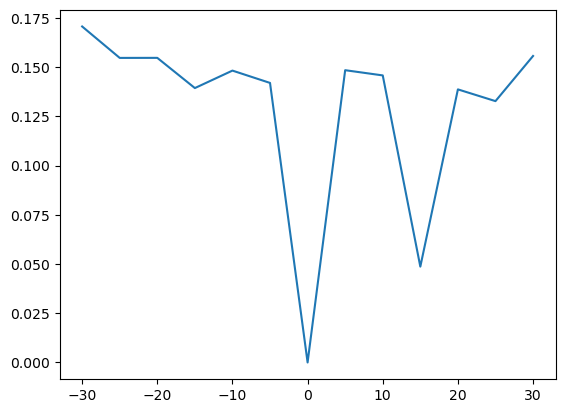

In [ ]:
MAE_dice_table.plot()

<Axes: >

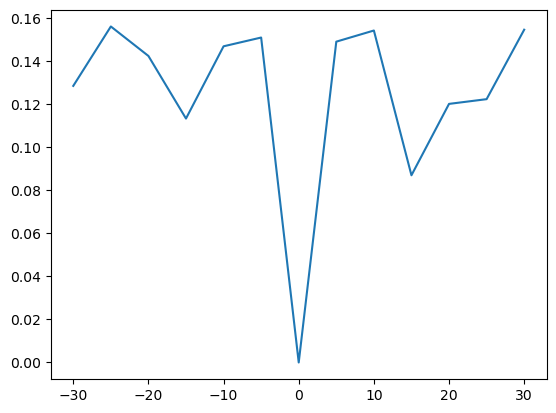

In [ ]:
MAE_sdice_table.plot()

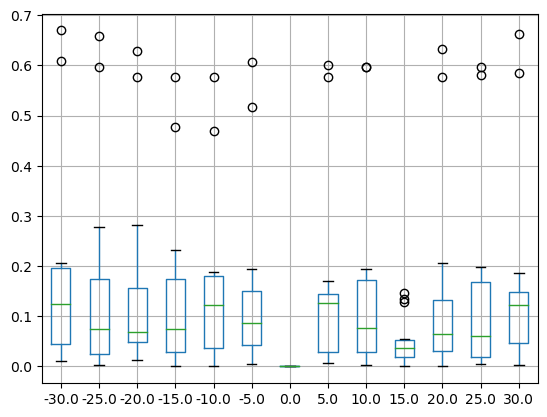

In [ ]:
boxplot = abs_err_dice_table.T.boxplot()  

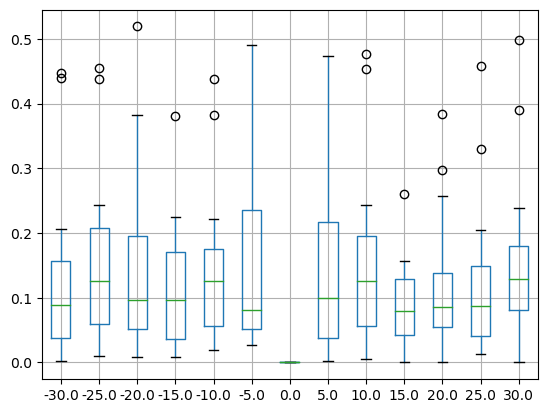

In [ ]:
boxplot = abs_err_sdice_table.T.boxplot()  